In [ ]:
#| echo: false
%load_ext autoreload
%autoreload 2

> Introducing two helper libraries to run dynamic Classifier-free Guidance. 

# Introduction

This post is a quick overview of two libraries:  

- `cf_guidance` 
- `min_diffusion`

These libraries were developed as part of a [series](https://enzokro.dev/blog/posts/2022-11-21-guidance-expts-2/) on dynamic Classifier-free Guidance (CFG).  

Dynamic CFG means that the guidance parameters change during the diffusion process. Specifically:  

- The predictions are normalized by their vector norms.  
- The guidance scalar $G$, also called $\gamma$, follows a schedule.  

## Motivation

The initial experiments had a lot of boilerplate and repeated code.  

For example, the same code was used in multiple notebooks to load Stable Diffusion models. The code for guidance schedules and normalizations was also repeated across notebooks.  

That meant that each notebook needed a lot of overhead before it got to the actual experiments.  

To make life a bit easier, and because we hope that these ideas are broadly usable, this repeated code was moved to two libraries:  

- `min_diffusion`
- `cf_guidance`  

Now we can import these libraries and jump straight to the important part: running the guidance experiments.  

# Using the libraries

First we import a few setup libraries to plot the examples. 

In [ ]:
import torch
import matplotlib.pyplot as plt

Next we show how to use the two new helper libraries.

## The `min_diffusion` library

In this section we generate an image using `min_diffsion`.  

In [ ]:
from min_diffusion.core import MinimalDiffusion

2022-11-22 15:42:08.507717: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


### Loading the `openjourney` model from Prompt Hero

The following code load the `openjourney` Stable Diffusion model on the GPU, in `torch.float16` precision.

In [ ]:
model_name = 'prompthero/openjourney'
device     = 'cuda'
dtype      = torch.float16

In [ ]:
pipeline = MinimalDiffusion(model_name, device, dtype)

In [ ]:
pipeline.load();

Enabling default unet attention slicing.


### Generating an image

Next we use the familiar prompt to generate an image:  

> "a photograph of an astronaut riding a horse"

:::: {.callout-note}  
The `openjourney` model was fine-tuned to create images in the style of [Midjourney v4](https://mezha.media/en/2022/11/11/midjourney-v4-is-an-incredible-new-version-of-the-ai-image-generator/).  

To enable this fine-tuned style, we have to add the keyword `"mdjrny-v4"` at the start of the prompt.  
::::

In [ ]:
# text prompt for image generations
prompt = "mdjrny-v4 style a photograph of an astronaut riding a horse"

In [ ]:
# set the seed for reproducibility
torch.manual_seed(2147483647);

In [ ]:
# generate the image
img = pipeline.generate(prompt);

Using the default Classifier-free Guidance.


  0%|          | 0/50 [00:00<?, ?it/s]

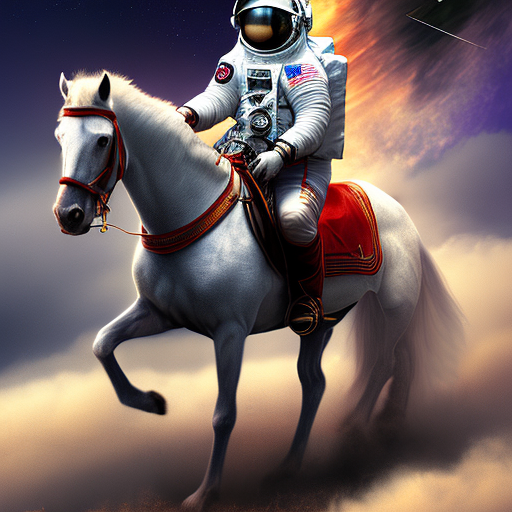

In [ ]:
# display the generated image
img

That's the entire process!  

The main difference between `MinimalDiffusion` and the HuggingFace API is that now we can easily customize the image generation loop. This allows us to explore a wide range of dynamic Classifier-free Guidances.  

## The `cf_guidance` library

The sections below are based on the [`cf_guidance` documentation](https://enzokro.github.io/guidance_transforms/).  

We create a few Cosine schedules and plug them into different Classifier-free Guidances.   

The schedule parameter come from the [initial post](https://enzokro.dev/blog/posts/2022-11-15-guidance-expts-1/) on dynamic Classifier-free Guidance. 

In [ ]:
from cf_guidance.schedules import get_cos_sched

In [ ]:
# Parameters from the blog post
# https://enzokro.dev/blog/posts/2022-11-15-guidance-expts-1/
max_val = 7.5
min_val = 0.15
num_steps = 50
num_warmup_steps = 5

# 1) Baseline cosine schedule
cos_params = {
    'max_val':           max_val,
    'num_steps':         num_steps,
    'min_val':           min_val,
    'num_warmup_steps':  0,
}

# 2) Cosine schedule with warmup 
warmup_cos_params = {
    'max_val':           max_val,
    'num_steps':         num_steps,
    'min_val':           min_val,
    'warmup_init_val':   min_val + 1., # to show we can offset the warmup relative to min
    'num_warmup_steps':  num_warmup_steps,
}

# create the schedules
cos_g = get_cos_sched(**cos_params)
warmup_g = get_cos_sched(**warmup_cos_params)

Let's plot these cosine schedules to see what they look like. 

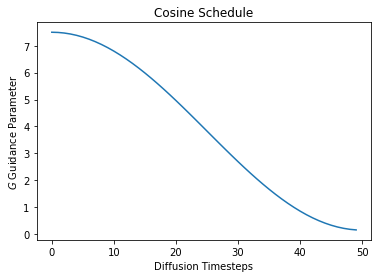

In [ ]:
# plot the schedules
plt.plot(cos_g)
plt.xlabel('Diffusion Timesteps')
plt.ylabel('$G$ Guidance Parameter')
plt.title('Cosine Schedule');

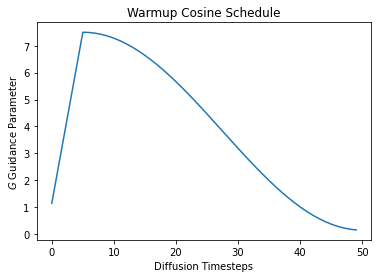

In [ ]:
plt.plot(warmup_g)
plt.xlabel('Diffusion Timesteps')
plt.ylabel('$G$ Guidance Parameter')
plt.title('Warmup Cosine Schedule');

### Creating Guidance Normalizers

Now we can use these schedules during Classifier-free Guidance. The Guidance Transform class, `GuidanceTfm`, makes this possible.  

Guidance transforms take one initialization parameter: `schedules`. This is a map from parameter names to an array-like, indexable sequence of values.\
For a given parameter `name` at diffusion timestep `idx`, the value of `schedules[name][idx]` should be the parameter's scheduled value at the given timestep.  

In this case we call the guidance parameter $G$ as a lowercase $g$.  

In [ ]:
from cf_guidance.transforms import GuidanceTfm, BaseNormGuidance

In [ ]:
# create the `schedules` parameter
example_schedules = {'g': cos_g}

# Create a Guidance with cosine schedule.
guidance = GuidanceTfm(example_schedules)

# Normalized Guidance with a cosine schedule.
norm_guidance = BaseNormGuidance(example_schedules)

### Using the transforms in a Diffusion pipeline

The following snippet shows where and how the Guidance Transforms are used in a diffusion loop.   

We use the `norm_guidance` example class created above. Specifically, we call `norm_guidance` with the following arguments:  

- The unconditioned noise predictions.  
- The conditional noise predictions.  
- The index of the current timestep.  

The code is borrowed from HuggingFace's [official `StableDiffusionPipeline`](https://github.com/nateraw/stable-diffusion-videos/blob/main/stable_diffusion_videos/stable_diffusion_pipeline.py#L448) to show where `norm_guidance` should go.\
This seems like a good starting point, since many scripts and functions are based on this HuggingFace setup.

```python
    # inside of `StableDiffusionPipeline`
    
    for i, t in enumerate(self.progress_bar(timesteps_tensor)):
        # expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # NOTE: our transforms go here:
        ###############################
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)

            ## OLD UPADTE
            #noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # NEW cf_guidance UPDATE
            noise_pred = norm_guidance(noise_pred_uncond, noise_pred_text, i)
```

### Creating more complex schedules

Our cosine scheduler is based on a combination of the schedulers in [timm](https://github.com/rwightman/pytorch-image-models/blob/main/timm/scheduler/cosine_lr.py) and [HuggingFace](https://github.com/huggingface/transformers/blob/v4.24.0/src/transformers/optimization.py#L104).  

It has a variety of parameters to support many schedule combinations as shown below.

In [ ]:
# cosine schedule with a full cycle
full_cycle = {
    'max_val':           max_val,
    'num_steps':         num_steps,
    'min_val':           min_val,
    'num_cycles':        1,
    'num_warmup_steps':  0,
}

# cosine schedule with k-decay
k_decay_cos = {
    'max_val':           max_val,
    'num_steps':         num_steps,
    'min_val':           min_val,
    'num_cycles':        1.5,
    'k_decay':           0.7,
    'warmup_init_val':   min_val + 1., # to show we can offset the warmup value
    'num_warmup_steps':  num_warmup_steps,
}

# create the schedules
full_cycle_sched = get_cos_sched(**full_cycle)
k_decay_sched = get_cos_sched(**k_decay_cos)


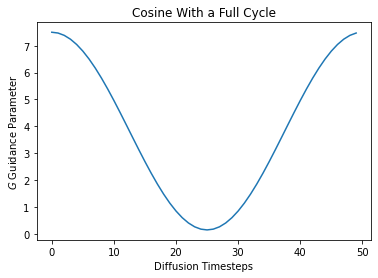

In [ ]:
plt.plot(full_cycle_sched)
plt.xlabel('Diffusion Timesteps')
plt.ylabel('$G$ Guidance Parameter')
plt.title('Cosine With a Full Cycle');

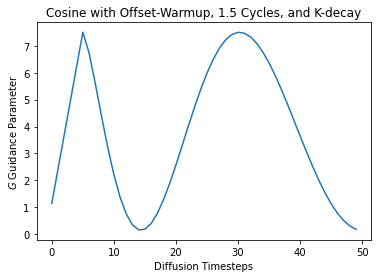

In [ ]:
plt.plot(k_decay_sched)
plt.xlabel('Diffusion Timesteps')
plt.ylabel('$G$ Guidance Parameter')
plt.title('Cosine with Offset-Warmup, 1.5 Cycles, and K-decay');

# Conclusion

This notebook was a quick introduction to two libraries:  

- `min_diffusion`  
- `cf_guidance`  


`min_diffusion` makes it easier to load Stable Diffusion models.   
`cf_guidance` makes it easier to create schedules and normalizations for dynamic Classifier-free Guidance.  

The next post in this series will use the libraries to keep exploring the effects of dynamically changing the Classifier-free Guidance.